In [64]:
import os
import PyPDF2
import fitz
import pandas as pd
import collections
import re

In [65]:
from nltk import tokenize
# import nltk
# nltk.download('punkt')

In [66]:
dir = 'annoted_sustainability_reports/Healthcare'
 

In [67]:
x_label = ["EliLilly", "UnitedHealthGroup", "Merck", "BristolMyersSquibb", "Danaher", "johnsonandjohnson", 
            "Pfizer", "Abbott", "ThermoFisherScientifiic", "Amgen"]

### Extracting Sentences: Refined Version

In [68]:
# this method will return a list of highlighted sentences in each page 
def get_page_highlights_coord(annot):
    page_highlights_coord = []
    while annot:
        if annot.type[0] == 8:
            all_coordinates = annot.vertices
            try:
                if len(all_coordinates) == 4:
                    highlight_coord = fitz.Quad(all_coordinates).rect
                    page_highlights_coord.append(highlight_coord)
                else:
                    all_coordinates = [all_coordinates[x:x+4] for x in range(0, len(all_coordinates), 4)]
                    for i in range(0,len(all_coordinates)):
                        coord = fitz.Quad(all_coordinates[i]).rect
                        page_highlights_coord.append(coord)
            except:
                print("NoneType found")
        annot = annot.next
    return page_highlights_coord
        

In [69]:
def get_page_highlights_text(page_highlights_coord, all_words, test_pos, repeat_coord):
    page_highlights = collections.defaultdict(list)
    for h in page_highlights_coord:
        test_dict = collections.defaultdict(list) # intialize a dictionary that keeps order and 
        # indication of where the sentence breaks occur
        for w in all_words:
            if (fitz.Rect(w[0:4]).intersects(h)): 
            # find intersections where the original report overlaps with the highlighted sentences
                new_pos = int(str("%02d" % w[5]) + str("%02d" % w[6]) + str("%02d" % w[7])) 
#                 print(new_pos, w[4])
                if new_pos not in repeat_coord:
                    repeat_coord.append(new_pos)
                    if test_pos <  new_pos:
#                         print('less than', test_pos, new_pos, w[4])
                        test_pos = new_pos 
                        test_dict[new_pos].append(w[4])
                        page_highlights[new_pos].append(test_dict[new_pos][0])
#                         page_highlights.append({new_pos : test_dict[new_pos]})
                    else:
#                         print('greater than', test_pos, new_pos, w[4])
                        test_dict = collections.defaultdict(list)
                        test_pos = 0
                        test_dict[new_pos].append(w[4])
                        page_highlights[new_pos].append(test_dict[new_pos][0])
#                         page_highlights.append({new_pos : test_dict[new_pos]})
                else:
                    continue
    return page_highlights
                    

In [70]:
def get_total_highlights_text(total_page_highlights):
    total_page_highlights_text = []
    for i in total_page_highlights:
        highlights = ""
        sorted_dict = sorted(i.items(), key = lambda kv:kv[0], reverse = False)
        for k in sorted_dict:
            highlights += k[1][0] + " "
            
        total_page_highlights_text.append(highlights)
    
    return total_page_highlights_text

In [71]:
# final list of relevant sentences
final_relevant = []   
final_relevant_comp = []

# final list of all sentences 
final_all = []
final_all_comp = []

# running all the files in the industry folder
for file in os.listdir(dir): 
    
    # f = filename + directory
    f = os.path.join(dir, file) 
    print(f)
    
    # comp_lab = to label sentence by companies
    comp_lab = list(filter(lambda x:  x in f, x_label))
    print(comp_lab)
    
    # opening each company report
    doc = fitz.open(f) 
    print(doc)
    
    # store the entire report in this list
    all_result = []
    
    test_pos = 0 # keep track of whether values of coordinates increase or decrease --> 
    #reinitialize if decreases because that means its a new set of sentences (paragraph)
    
    total_page_highlights = [] # use this list to store all the highlighted sentences of each page
    
#     test_final_relevant = [] # use this to test printing relevant sentences by company 

    # iterate each page of the document
    for page in doc:
        
        # extract all the sentences in pdf --> store it in all_result
        all_text = page.get_text_words()
        all_text = [i[4] for i in all_text]
        all_result.append(" ".join(all_text))
        
        # extract highlighted sentences coordinates from pdf --> using the get_page_highlights_coord method
        annot = page.first_annot
        page_highlights_coord = get_page_highlights_coord(annot)
        
        # convert the page into text so that it can be compared with highlighted coordinates
        all_words = page.get_text_words()
#         print(all_words)
        
        # only iterate if highlights were detected
        if len(page_highlights_coord) > 0:
            repeat_coord = []
            # use the get_page_highlights_text to extract coordinates and words into dictionary 
            #(remove duplicated coordinates here as well)
            page_highlights = get_page_highlights_text(page_highlights_coord, all_words, test_pos, repeat_coord)
            total_page_highlights.append(page_highlights)
            
    # use get_total_highlights_text method to sort words by coordinates 
    # [so that we can get a cleaner version of sentences] and extract the final version of relevant sentences        
    total_highlights = get_total_highlights_text(total_page_highlights)
    
    # loop around total_highlights to tokenize sentences (breaking chunks into sentences)
    for i in total_highlights:
        i = re.sub("\xa0", " ", i)
        i = re.sub("\t", " ", i)
        i = re.sub("\r", " ", i)
        i = re.sub("\n", " ", i)
        i = re.sub(" +", " ", i)
#         i = i.strip()
        final_relevant += tokenize.sent_tokenize(i)
        final_relevant_comp += comp_lab * len(tokenize.sent_tokenize(i))
    
#     print('>>>>RELEVANT<<<<')
#     print(final_relevant)
#         test_final_relevant += tokenize.sent_tokenize(i.replace("\n", " "))

    # loop around all_result to tokenize sentences as well
    for i in all_result:
        i = re.sub("\xa0", " ", i)
        i = re.sub("\t", " ", i)
        i = re.sub("\r", " ", i)
        i = re.sub("\n", " ", i)
        i = re.sub(" +", " ", i)
#         i = i.strip()
        final_all += tokenize.sent_tokenize(i)
        final_all_comp += comp_lab * len(tokenize.sent_tokenize(i))
        
#     print('>>>>ALL<<<<')
#     print(final_all)

            


annoted_sustainability_reports/Healthcare/EliLilly_2021_Environmental_ESG_report.pdf
['EliLilly']
Document('annoted_sustainability_reports/Healthcare/EliLilly_2021_Environmental_ESG_report.pdf')
annoted_sustainability_reports/Healthcare/UnitedHealthGroup_2021-sustainability-report.pdf
['UnitedHealthGroup']
Document('annoted_sustainability_reports/Healthcare/UnitedHealthGroup_2021-sustainability-report.pdf')
annoted_sustainability_reports/Healthcare/Merck_2021_ESG_report.pdf
['Merck']
Document('annoted_sustainability_reports/Healthcare/Merck_2021_ESG_report.pdf')
annoted_sustainability_reports/Healthcare/BristolMyersSquibb_2020_ESG.pdf
['BristolMyersSquibb']
Document('annoted_sustainability_reports/Healthcare/BristolMyersSquibb_2020_ESG.pdf')
annoted_sustainability_reports/Healthcare/Danaher_2021_sustainability_report.pdf
['Danaher']
Document('annoted_sustainability_reports/Healthcare/Danaher_2021_sustainability_report.pdf')
annoted_sustainability_reports/Healthcare/johnsonandjohnson_20

### Relevant & All Sentences into a DataFrame

In [72]:
rel_text_df = pd.DataFrame([final_relevant, final_relevant_comp]).transpose().rename(columns = {0: 'relevant_sentences', 1: 'company_label'})
rel_text_df.head()

,relevant_sentences,company_label
0,"In 2021, 9.6% of our purchased electricity cam...",EliLilly
1,A large portion of this renewable electricity ...,EliLilly
2,"From 2012 to 2020, we achieved a 26% reduction...",EliLilly
3,"In 2021, we achieved a 9% absolute emissions r...",EliLilly
4,This reduction was partially driven by energy ...,EliLilly


In [73]:
all_text_df = pd.DataFrame([final_all, final_all_comp]).transpose().rename(columns = {0: 'all_sentences', 1: 'company_label'})
all_text_df.head()

,all_sentences,company_label
0,"7/7/22, 10:29 AM Environmental | 2021 ESG Repo...",EliLilly
1,Making medicines requires the use of valuable ...,EliLilly
2,We’re committed to reducing our environmental ...,EliLilly
3,"To track our progress, we measure and manage e...",EliLilly
4,"Lilly manages health, safety and the environme...",EliLilly


### Relevant Sentences Statistics

In [74]:
rel_text_df.groupby('company_label', sort = False).count()

,relevant_sentences
company_label,
EliLilly,16
Merck,13
BristolMyersSquibb,5
Danaher,2
johnsonandjohnson,14
Pfizer,1
Abbott,10
ThermoFisherScientifiic,7
Amgen,4


In [75]:
all_text_df.groupby('company_label', sort = False).count()

,all_sentences
company_label,
EliLilly,105
UnitedHealthGroup,1065
Merck,2464
BristolMyersSquibb,1211
Danaher,945
johnsonandjohnson,2118
Pfizer,59
Abbott,2141
ThermoFisherScientifiic,921


### Getting Sentence Statistics 

In [76]:
# count rel sentences 
rel_count = rel_text_df.groupby('company_label', sort = False).count()

# count all sentences
sent_count = all_text_df.groupby('company_label', sort = False).count()

In [77]:
sentences_list = []
rel_sent_list = []

final_text_stat = pd.concat([sent_count, rel_count],  sort = False, axis = 1)

[rel_sent_list.append(rel_sent) for rel_sent in final_text_stat['relevant_sentences']]    
[sentences_list.append(all_sent) for all_sent in final_text_stat['all_sentences']]    
    
final_text_stat['relevant_sentences'] = final_text_stat['relevant_sentences'].fillna(0)
final_text_stat['percentages'] = final_text_stat['relevant_sentences'] / final_text_stat['all_sentences'] * 100
final_text_stat

,all_sentences,relevant_sentences,percentages
company_label,,,
EliLilly,105,16.0,15.238095
UnitedHealthGroup,1065,0.0,0.000000
Merck,2464,13.0,0.527597
BristolMyersSquibb,1211,5.0,0.412882
Danaher,945,2.0,0.211640
johnsonandjohnson,2118,14.0,0.661001
Pfizer,59,1.0,1.694915
Abbott,2141,10.0,0.467071
ThermoFisherScientifiic,921,7.0,0.760043


In [78]:
rel_sent_list

[16.0, nan, 13.0, 5.0, 2.0, 14.0, 1.0, 10.0, 7.0, 4.0]

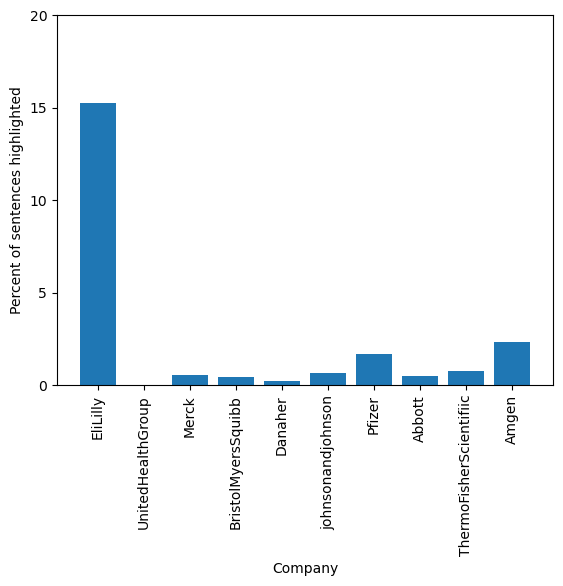

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import glob
y = []

i = 0

for file in os.listdir(dir):
    y.append(100 * (rel_sent_list[i])/sentences_list[i])
    i = i+1

plt.bar(x_label, y, width = 0.8)
plt.xticks(rotation='vertical')
plt.xlabel("Company")
plt.ylabel("Percent of sentences highlighted")
plt.yticks(np.arange(0, 25, 5))
plt.show()

In [80]:
import pandas as pd

series = pd.Series(y)
series.describe()

count     9.000000
mean      2.480687
std       4.834132
min       0.211640
25%       0.467071
50%       0.661001
75%       1.694915
max      15.238095
dtype: float64

### Exporting and Saving Files 

In [81]:
#storing variable so they can be called between notebooks (for ML and aggregate work later on)

HC_reltext = rel_text_df
HC_alltext = all_text_df
HC_stat = final_text_stat

%store HC_reltext
%store HC_alltext
%store HC_stat

Stored 'HC_reltext' (DataFrame)
Stored 'HC_alltext' (DataFrame)
Stored 'HC_stat' (DataFrame)
